# Data & Imports

In [1]:
# time meausre
import time
import math
start_time = time.time()

def print_time(execution_time):
    hours = int(math.floor(int(execution_time)/3600))
    minutes = int(math.floor((execution_time/3600-hours)*60))
    seconds = execution_time%60
    print("--- Total: %i hours, %i minutes, %f seconds  ---" % (hours,minutes,seconds))

In [2]:
import keras
import autokeras as ak
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


# constants
path = 'C:/Users/Asus/Documents/2023_2/Memoria/src'
#path = 'C:/Users/Monte/Documents/Memoria/src'

# seeds
global_seed = 19
# np.random.seed(seed=global_seed) # seed gets seted by statement below
keras.utils.set_random_seed(global_seed)
tf.config.experimental.enable_op_determinism()

# Ostar
O_df = pd.read_csv(path+'/Data/o_spectral_lines_trim.csv')
# Bstar
B_df = pd.read_csv(path+'/Data/b_spectral_lines_trim.csv')
# Observed spectra
Obs_df = pd.read_csv(path+'/Data/observed_spectral_lines_trim_v2.csv')

Using TensorFlow backend


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

target = ['temperature','g','v']


X = B_df.drop(target,axis = 1)
Y = B_df[target]
X_obs = Obs_df.drop(target+['HD','date','time'],axis=1)
Y_obs = Obs_df[target]

X = np.random.normal(loc=0, scale=0.01, size=X.shape) + X
y_scaler = MinMaxScaler()

x_train, x_val, y_train, y_val = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=global_seed)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, train_size=0.75, test_size=0.25, random_state=global_seed)

y_scaler = y_scaler.fit(y_train)
y_train = y_scaler.transform(y_train)
y_val = y_scaler.transform(y_val)
y_test = y_scaler.transform(y_test)
y_obs = y_scaler.transform(Y_obs.values)

formatted_x_train = np.expand_dims(x_train, axis=2) #This step it's very important an CNN will only accept this data shape
formatted_x_val = np.expand_dims(x_val, axis=2)
formatted_x_test = np.expand_dims(x_test, axis=2)
formatted_x_obs = np.expand_dims(X_obs, axis=2)


c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [4]:
# Density plot function

# https://kdepy.readthedocs.io/en/latest/examples.html#minimal-working-example-with-options
from KDEpy import FFTKDE
from sklearn.neighbors import KernelDensity
import numpy as np

measure = ['Temperature','log g', 'v sini']
measure_unit = ['[K]', '[u]', '[km/s]']

def SKL_density_plot(data, ax,low_bound=None,up_bound=None,title='', color='black',alpha=1,label='',kernel='gaussian', bw='silverman',linewidth=1):
  
	if low_bound != None and up_bound != None:
		bw = FFTKDE(bw=bw, kernel='gaussian').fit(data).bw
		kde = KernelDensity(bandwidth=bw, kernel=kernel).fit(data.reshape(-1,1))
		data = np.concatenate((data, 2 * low_bound - data, 2 * up_bound - data))
		kde = KernelDensity(bandwidth=kde.bandwidth_, kernel=kernel).fit(data.reshape(-1,1))
		x = np.linspace(low_bound,up_bound,1000)
		y = np.exp(kde.score_samples(x.reshape(-1,1)))
		plot_y = y[np.where((x>=low_bound) & (x<=up_bound))] # Set the KDE to zero outside of the domain
		plot_x = x[np.where((x>=low_bound) & (x<=up_bound))]  # Set the KDE to zero outside of the domain
		plot_y = plot_y * 3  # Double the y-values to get integral of ~1
		ax.plot(plot_x, plot_y, label=label,color=color,alpha=alpha,linewidth=linewidth)
		return x, y, kde
	else:
		kde = KernelDensity(bandwidth=bw, kernel=kernel).fit(data.reshape(-1,1))
		x=np.linspace(data.min(),data.max(),1000)
		y = np.exp(kde.score_samples(x.reshape(-1,1)))
		ax.plot(x, y, label=label,color=color,alpha=alpha)
		return x, y, kde

# AutoModel

In [5]:
from keras_tuner.engine import hyperparameters as hp

# convBlock
conv_kernel_size = hp.Choice("kernel_size", [3,5,7,9],)
conv_num_layers = hp.Choice("conv_layers", [1,2,3,4,5],)
conv_num_blocks = hp.Choice("conv_blocks", [1,2,3],)
conv_filters = hp.Choice("filters", [32,64,128,256,512],)

# # DenseBlock
dense_num_layers = hp.Choice("dense_layers", [1,2,3])
dense_units = hp.Choice("dense_units", [32,64,128,256,512])

# RegressionHead
# head_dropout = hp.Float(
#                 'dropout_head',
#                 min_value=0.0,
#                 max_value=0.5,
#                 default=0.25,
#                 step=0.05,
#             )

input = ak.Input()
conv = ak.ConvBlock(
  	kernel_size=conv_kernel_size,
  	num_blocks=conv_num_blocks,
  	num_layers=conv_num_layers,
  	filters=conv_filters,
  	max_pooling=True,
		separable=False,
  	#dropout=conv_dropout,
)(input)
dense = ak.DenseBlock(
  	num_layers=dense_num_layers, 
  	num_units=dense_units, 
  	use_batchnorm=False, 
  	#dropout=dense_dropout
)(conv)
regression_output = ak.RegressionHead(
  	output_dim=3, 
   	loss="mse", 
    metrics=["mae"], 
    #dropout=head_dropout,
)(dense)


def generateAutoModel():
  return ak.AutoModel(
	inputs=input,
	outputs=regression_output,
	max_trials=1,
	loss='mse',
	metrics = 'mae',
	tuner='bayesian',
	overwrite=False,
	seed=global_seed,
	max_model_size=None,)

model = generateAutoModel()


Reloading Tuner from .\auto_model\tuner0.json


In [6]:
# set timer
curr_time = time.time()

In [7]:
# 6 hrs, 15 min 100 modelos
# 28 hrs 500 modelos
model.fit(formatted_x_train, y_train,validation_data=(formatted_x_val, y_val), epochs=20)



Epoch 1/20
459/459 [==============================] - 9s 12ms/step - loss: 0.0984 - mae: 0.2545 - val_loss: 0.0529 - val_mae: 0.1856
Epoch 2/20
459/459 [==============================] - 5s 11ms/step - loss: 0.0548 - mae: 0.1829 - val_loss: 0.0376 - val_mae: 0.1409
Epoch 3/20
459/459 [==============================] - 5s 11ms/step - loss: 0.0458 - mae: 0.1656 - val_loss: 0.0357 - val_mae: 0.1391
Epoch 4/20
459/459 [==============================] - 5s 11ms/step - loss: 0.0422 - mae: 0.1583 - val_loss: 0.0301 - val_mae: 0.1268
Epoch 5/20
459/459 [==============================] - 5s 11ms/step - loss: 0.0394 - mae: 0.1534 - val_loss: 0.0289 - val_mae: 0.1259
Epoch 6/20
459/459 [==============================] - 5s 11ms/step - loss: 0.0366 - mae: 0.1473 - val_loss: 0.0246 - val_mae: 0.1152
Epoch 7/20
459/459 [==============================] - 5s 11ms/step - loss: 0.0345 - mae: 0.1429 - val_loss: 0.0210 - val_mae: 0.1039
Epoch 8/20
459/459 [==============================] - 5s 11ms/step - 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


In [8]:
# execution time print
print_time(float(time.time() - curr_time))

--- Total: 0 hours, 1 minutes, 51.993089 seconds  ---


In [9]:
exp = model.export_model()
exp.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 139, 1)]          0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 139, 1)           0         
 t32)                                                            
                                                                 
 conv1d (Conv1D)             (None, 131, 128)          1280      
                                                                 
 conv1d_1 (Conv1D)           (None, 123, 512)          590336    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 15, 512)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 7680)              0     

In [10]:
# Evaluate the best model with testing data.
evaluation = model.evaluate(formatted_x_test, y_test)

print('loss: %.3f  MAE:%.3f'% (evaluation[0],evaluation[1]))

153/153 [==============================] - 1s 5ms/step - loss: 0.0151 - mae: 0.0868
loss: 0.015  MAE:0.087


In [11]:
predictions = model.predict(formatted_x_test)

153/153 [==============================] - 0s 3ms/step


In [12]:
losses = []
maes = []

for i in range(len(target)):
  losses.append(np.mean((predictions[:,i]-y_test[:,i])**2))
  maes.append(np.mean(np.abs(predictions[:,i]-y_test[:,i])))
  
print('Temperatura - loss: %.3f  MAE:%.3f'% (losses[0],maes[0]))
print('log g -       loss: %.3f  MAE:%.3f'% (losses[1],maes[1]))
print('v -           loss: %.3f  MAE:%.3f'% (losses[2],maes[2]))


Temperatura - loss: 0.025  MAE:0.114
log g -       loss: 0.018  MAE:0.108
v -           loss: 0.002  MAE:0.039


In [13]:
# / TODO: error de perdida para cada parametro
# / TODO: grafica de valor esperado vs prediccion para espectro observado
# TODO: fijar casos borde para espectros observados(grafica)
# TODO: agregar chi a la tabla

### Prediccion de datos de testing (modelo unico)

In [14]:
predictions = y_scaler.inverse_transform(predictions)

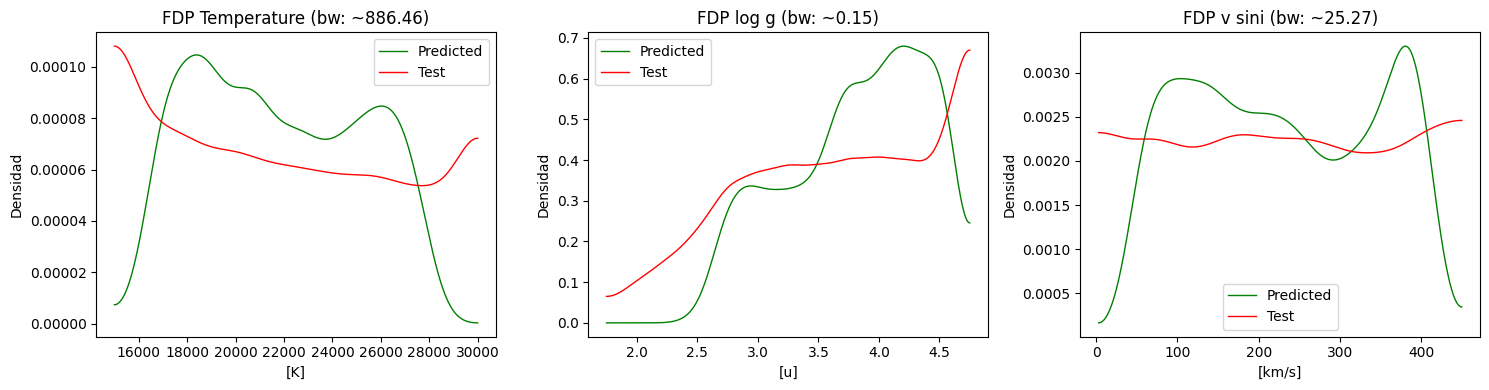

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))

for i, featureName in enumerate(target):
	x, y, kde = SKL_density_plot(predictions[:,i], axes[i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color = 'green',label='Predicted')
	x, y, kde = SKL_density_plot(y_scaler.inverse_transform(y_test)[:,i], axes[i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color='red',label='Test')
	measure = ['Temperature','log g', 'v sini']
	measure_unit = ['[K]', '[u]', '[km/s]']
	axes[i].set_xlabel(measure_unit[i])
	axes[i].set_ylabel('Densidad')
	axes[i].set_title('FDP '+measure[i]+' (bw: ~%.2f'%(kde.bandwidth_)+')')
	axes[i].legend()

plt.legend()
plt.tight_layout();
plt.show()

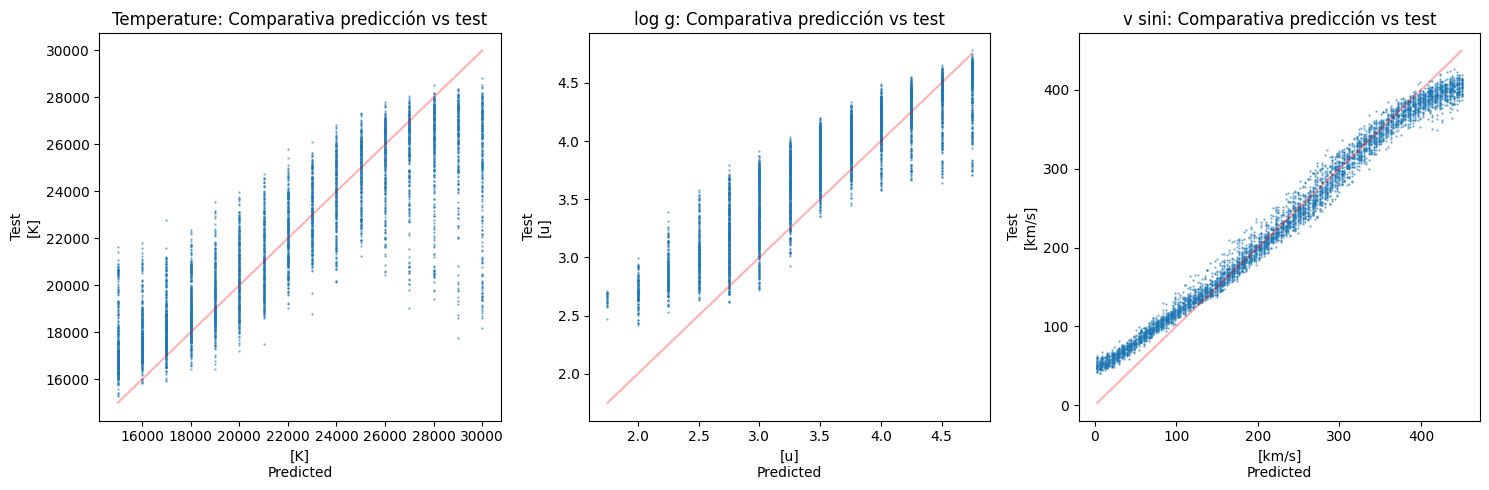

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for i, featureName in enumerate(target):
	x_space = np.linspace(y_scaler.inverse_transform(y_test)[:,i].min(), y_scaler.inverse_transform(y_test)[:,i].max(), 100)
	axes[i].scatter(x=y_scaler.inverse_transform(y_test)[:,i],y=predictions[:,i],s=0.5,alpha=0.5)
	axes[i].plot(x_space,x_space,c='red',alpha=0.3)
	axes[i].set_xlabel(measure_unit[i]+'\nPredicted')
	axes[i].set_ylabel('Test\n'+measure_unit[i])
	axes[i].set_title(measure[i]+': Comparativa predicción vs test')
 
plt.tight_layout();
plt.show()

c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


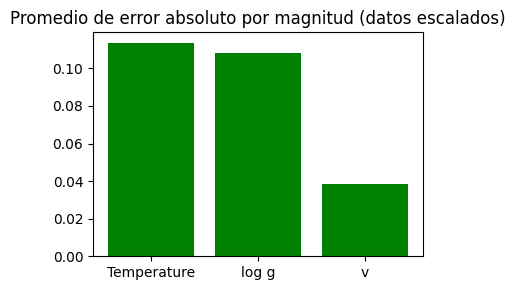

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4,3))
x_data = ['Temperature','log g','v']

diff = np.mean(np.abs(y_scaler.transform(predictions)-y_test),axis=0)
axes.bar(x_data,diff, color='green')
axes.set_title('Promedio de error absoluto por magnitud (datos escalados)')
plt.tight_layout();
plt.show()


In [18]:
#data formatting
inverse_y_test = y_scaler.inverse_transform(y_test)
rel_error = np.abs(predictions-inverse_y_test)*(1/inverse_y_test)*100
abs_error = np.abs(predictions-inverse_y_test)

table_formatted_temperature = [str(round(i)) for i in np.round(inverse_y_test[:,0],0)]
table_formatted_log_g = [str(round(i,2)) for i in np.round(inverse_y_test[:,1],2)]
table_formatted_v = [str(round(i)) for i in np.round(inverse_y_test[:,2],0)]

table_formatted_temperature_pred = [str(round(i)) for i in predictions[:,0]]
table_formatted_log_g_pred = [str(round(i,2)) for i in predictions[:,1]]
table_formatted_v_pred = [str(round(i)) for i in predictions[:,2]]

table_formatted_temperature_error = [str(round(i))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,0],rel_error[:,0])]
table_formatted_log_g_error = [str(round(i))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,1],rel_error[:,1])]
table_formatted_v_error = [str(round(i))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,2],rel_error[:,2])]

In [19]:
# table plot
results = pd.DataFrame({
  'Temperatura':table_formatted_temperature,'Prediccion_Temp':table_formatted_temperature_pred,'Temp_Error_Abs(Rel)':table_formatted_temperature_error,
  'log_g':table_formatted_log_g,'Prediccion_log_g':table_formatted_log_g_pred,'log_g_Error_Abs(Rel)':table_formatted_log_g_error,
  'v':table_formatted_v,'Prediccion_v':table_formatted_v_pred,'v_Error_Abs(Rel)':table_formatted_v_error,

                    })
results.head(10)

,Temperatura,Prediccion_Temp,Temp_Error_Abs(Rel),log_g,Prediccion_log_g,log_g_Error_Abs(Rel),v,Prediccion_v,v_Error_Abs(Rel)
0,17000,17724,724 (4.3%),3.0,3.74,0 (15.2%),246,243,3 (1.3%)
1,18000,17150,850 (4.7%),3.0,3.42,1 (24.4%),285,269,16 (5.7%)
2,30000,25223,4777 (15.9%),4.0,3.82,0 (1.8%),267,254,13 (5.0%)
3,23000,22140,860 (3.7%),2.0,2.8,0 (11.9%),63,89,26 (41.8%)
4,19000,21159,2159 (11.4%),3.0,3.34,0 (11.4%),126,140,14 (11.2%)
5,17000,16750,250 (1.5%),4.0,4.13,0 (8.2%),156,177,21 (13.3%)
6,28000,22767,5233 (18.7%),3.0,3.42,0 (5.2%),450,402,48 (10.6%)
7,22000,20801,1199 (5.4%),4.0,4.27,0 (6.7%),285,292,7 (2.5%)
8,23000,23287,287 (1.2%),3.0,3.21,0 (7.0%),30,61,31 (102.1%)
9,23000,22523,477 (2.1%),4.0,4.55,0 (1.2%),153,161,8 (5.0%)


### Datos observados vs predicción de modelo único

In [20]:
predictions = model.predict(formatted_x_obs)

3/3 [==============================] - 0s 17ms/step


In [21]:
losses = []
maes = []

for i in range(len(target)):
  losses.append(np.mean((predictions[:,i]-y_obs[:,i])**2))
  maes.append(np.mean(np.abs(predictions[:,i]-y_obs[:,i])))
  
print('Temperatura - loss: %.3f  MAE:%.3f'% (losses[0],maes[0]))
print('log g -       loss: %.3f  MAE:%.3f'% (losses[1],maes[1]))
print('v -           loss: %.3f  MAE:%.3f'% (losses[2],maes[2]))


Temperatura - loss: 0.244  MAE:0.411
log g -       loss: 0.018  MAE:0.113
v -           loss: 0.034  MAE:0.129


In [22]:
predictions = y_scaler.inverse_transform(predictions)

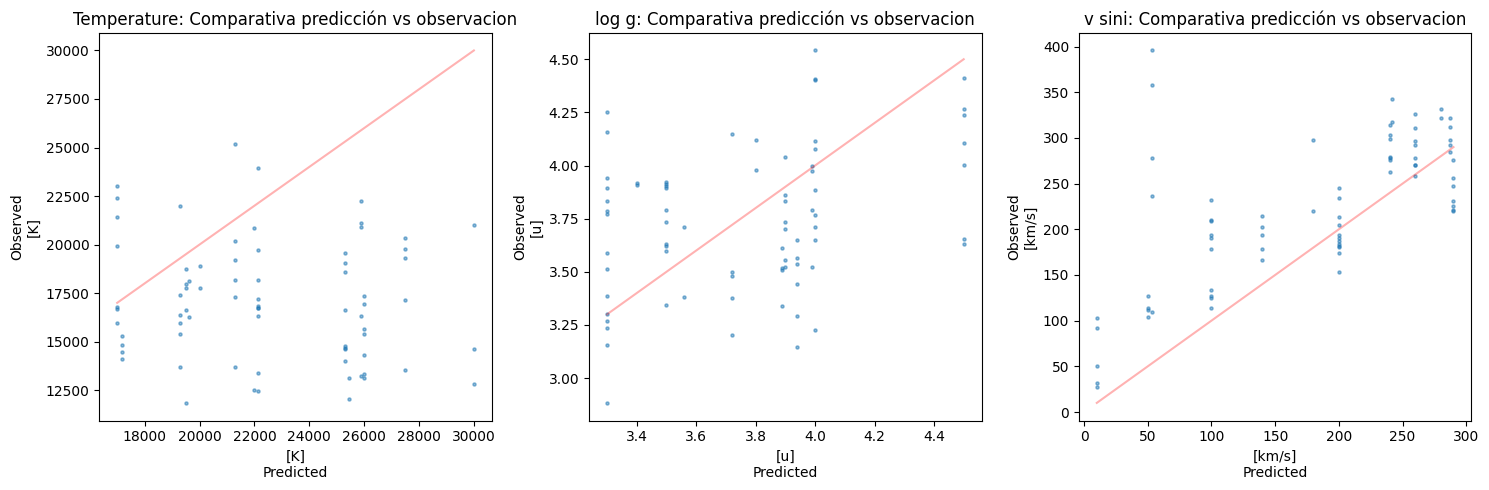

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for i, featureName in enumerate(target):
	x_space = np.linspace(y_scaler.inverse_transform(y_obs)[:,i].min(), y_scaler.inverse_transform(y_obs)[:,i].max(), 100)
	axes[i].scatter(x=y_scaler.inverse_transform(y_obs)[:,i],y=predictions[:,i],s=5,alpha=0.5)
	axes[i].plot(x_space,x_space,c='red',alpha=0.3)
	axes[i].set_xlabel(measure_unit[i]+'\nPredicted')
	axes[i].set_ylabel('Observed\n'+measure_unit[i])
	axes[i].set_title(measure[i]+': Comparativa predicción vs observacion')
 
plt.tight_layout();
plt.show()

In [24]:
# xi
def xi(obs,sint):
  return np.sum((obs - sint)**2/sint)
def get_closest_spectra_line(index):
  obs = formatted_x_obs[index]
  min_dist = np.inf
  min_dist_index = -1
  for i, sint in enumerate(x):
    
    d = xi(obs, sint)
    if d < min_dist:
      min_dist = d
      min_dist_index = i
      
  return min_dist, min_dist_index

In [25]:
# find closest parameters
import numpy as np
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx
  
nearest = []
for obs_parameters in Y_obs.to_numpy():
	neighbor = []
	for param_index in range(len(target)):
		v, _ = find_nearest(Y.iloc[:,param_index].values,obs_parameters[param_index])
		neighbor.append(v)
	nearest.append(neighbor)
 
nearest_index = []
for neighbor in nearest:
	nearest_index.append(Y[(Y.temperature == neighbor[0]) & (Y.g == neighbor[1]) & (Y.v == neighbor[2])].index[0])

In [26]:
#data formatting
inverse_y_obs = y_scaler.inverse_transform(y_obs)
rel_error = np.abs(predictions-inverse_y_obs)*(1/inverse_y_obs)*100
abs_error = np.abs(predictions-inverse_y_obs)
#close = np.array([get_closest_spectra_line(index) for index in range(len(X_obs))])[:,0]

table_formatted_temperature = [str(round(i)) for i in np.round(inverse_y_obs[:,0],0)]
table_formatted_log_g = [str(round(i,3)) for i in np.round(inverse_y_obs[:,1],1)]
table_formatted_v = [str(round(i)) for i in np.round(inverse_y_obs[:,2],0)]

table_formatted_temperature_pred = [str(round(i)) for i in predictions[:,0]]
table_formatted_log_g_pred = [str(round(i,2)) for i in predictions[:,1]]
table_formatted_v_pred = [str(round(i)) for i in predictions[:,2]]

table_formatted_temperature_error = [str(round(i))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,0],rel_error[:,0])]
table_formatted_log_g_error = [str(round(i,2))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,1],rel_error[:,1])]
table_formatted_v_error = [str(round(i))+' ('+str(round(j,1))+'%)' for i,j in zip(abs_error[:,2],rel_error[:,2])]

# xi es la distancia entre el espectro observado y el espectro sintetico que tiene parámetros más cercanos a la estrella
table_formatted_xi = [xi(obs,sint) for obs, sint in zip(formatted_x_obs,X.iloc[nearest_index].to_numpy())]


In [27]:
# tabla de resultados modelo unico sobre datos observados

results = pd.DataFrame({
  'Temperatura':table_formatted_temperature,'Prediccion_Temp':table_formatted_temperature_pred,'Temp_Error_Abs(Rel)':table_formatted_temperature_error,
  'log_g':table_formatted_log_g,'Prediccion_log_g':table_formatted_log_g_pred,'log_g_Error_Abs(Rel)':table_formatted_log_g_error,
  'v':table_formatted_v,'Prediccion_v':table_formatted_v_pred,'v_Error_Abs(Rel)':table_formatted_v_error,
  'paramCloseXi': table_formatted_xi
                    })
Obs_df[['HD','date','time']].join(results).set_index('HD').head(60)

,date,time,Temperatura,Prediccion_Temp,Temp_Error_Abs(Rel),log_g,Prediccion_log_g,log_g_Error_Abs(Rel),v,Prediccion_v,v_Error_Abs(Rel),paramCloseXi
HD,,,,,,,,,,,,
33328,2012-11-13,05-37-18,19526,16612,2914 (14.9%),3.3,3.89,0.59 (18.0%),287,285,2 (0.8%),100.145347
33328,2013-01-18,03-39-09,19526,17990,1536 (7.9%),3.3,3.79,0.49 (14.7%),287,292,5 (1.8%),88.230602
33328,2013-02-26,00-55-34,19526,18742,784 (4.0%),3.3,3.77,0.47 (14.3%),287,298,11 (3.7%),93.982720
33328,2015-02-25,23-58-07,19526,11846,7680 (39.3%),3.3,4.25,0.95 (28.8%),287,321,34 (12.0%),116.914635
33328,2015-02-26,00-19-03,19526,17740,1786 (9.1%),3.3,4.16,0.86 (26.0%),287,311,24 (8.5%),111.190865
35165,2014-03-20,23-53-54,17000,16688,312 (1.8%),4.0,4.41,0.41 (10.2%),240,299,59 (24.5%),175.906493
35165,2014-03-21,00-14-49,17000,16781,219 (1.3%),4.0,4.54,0.54 (13.5%),240,280,40 (16.5%),172.360638
35165,2014-03-21,00-35-18,17000,15957,1043 (6.1%),4.0,4.08,0.08 (1.9%),240,276,36 (14.9%),172.762155
35165,2015-11-14,04-22-43,17000,22377,5377 (31.6%),4.0,3.65,0.35 (8.8%),240,304,64 (26.5%),162.566641


In [28]:
# / TODO ponerle titulo a las cosas 
# / TODO mostrar tabla con datos sintéticos
# / TODO mostrar fdp datos sinteticos
# / TODO mostrar resultados prediccion de datos observados
# TODO distribucion predictiva de datos observados
# / TODO agregar ruido a todas las particiones de x 
# / TODO mostrar el error
# / TODO graficar comparativa de espectro observado con sintetico
# / TODO entender como se llego a la red nuronal
# / TODO volver a generar instancia de entrenamiento de autokeras

# Ensemble

In [29]:
# set timer
curr_time = time.time()

In [30]:
from scipy.sparse import coo_matrix
from sklearn.utils import resample

NUM_MODELS = 5
models = []
history = []

x_train_sparse = coo_matrix(x_train)

for i in range(NUM_MODELS):
	keras.utils.set_random_seed(i)
	am = generateAutoModel()
	x_train_resampled, x_train_sparse, y_train_resampled = resample(x_train, x_train_sparse, y_train, random_state=i)
	x_train_resampled = np.expand_dims(x_train_resampled, axis=2)
	history.append(am.fit(x=x_train_resampled, y=y_train_resampled, epochs=30))
	models.append(am.export_model())

Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 5s 11ms/step - loss: 0.1094 - mae: 0.2713
Epoch 2/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0583 - mae: 0.1906
Epoch 3/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0415 - mae: 0.1579
Epoch 4/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0351 - mae: 0.1448
Epoch 5/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0322 - mae: 0.1374
Epoch 6/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0311 - mae: 0.1350
Epoch 7/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0305 - mae: 0.1338
Epoch 8/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0299 - mae: 0.1325
Epoch 9/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0290 - mae: 0.1302
Epoch 10/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0277 - mae: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 5s 11ms/step - loss: 0.1062 - mae: 0.2630
Epoch 2/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0538 - mae: 0.1816
Epoch 3/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0397 - mae: 0.1545
Epoch 4/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0356 - mae: 0.1456
Epoch 5/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0340 - mae: 0.1422
Epoch 6/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0324 - mae: 0.1387
Epoch 7/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0316 - mae: 0.1369
Epoch 8/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0315 - mae: 0.1366
Epoch 9/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0310 - mae: 0.1357
Epoch 10/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0298 - mae: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 5s 11ms/step - loss: 0.1106 - mae: 0.2722
Epoch 2/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0615 - mae: 0.1970
Epoch 3/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0476 - mae: 0.1700
Epoch 4/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0434 - mae: 0.1623
Epoch 5/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0387 - mae: 0.1526
Epoch 6/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0349 - mae: 0.1438
Epoch 7/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0339 - mae: 0.1422
Epoch 8/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0330 - mae: 0.1401
Epoch 9/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0320 - mae: 0.1377
Epoch 10/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0321 - mae: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 5s 11ms/step - loss: 0.1118 - mae: 0.2775
Epoch 2/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0708 - mae: 0.2170
Epoch 3/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0492 - mae: 0.1735
Epoch 4/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0435 - mae: 0.1628
Epoch 5/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0375 - mae: 0.1504
Epoch 6/30
459/459 [==============================] - 5s 10ms/step - loss: 0.0350 - mae: 0.1436
Epoch 7/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0336 - mae: 0.1406
Epoch 8/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0326 - mae: 0.1382
Epoch 9/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0322 - mae: 0.1372
Epoch 10/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0313 - mae: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/30
459/459 [==============================] - 5s 11ms/step - loss: 0.1010 - mae: 0.2561
Epoch 2/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0548 - mae: 0.1836
Epoch 3/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0433 - mae: 0.1616
Epoch 4/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0382 - mae: 0.1513
Epoch 5/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0348 - mae: 0.1436
Epoch 6/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0332 - mae: 0.1399
Epoch 7/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0320 - mae: 0.1373
Epoch 8/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0299 - mae: 0.1322
Epoch 9/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0287 - mae: 0.1293
Epoch 10/30
459/459 [==============================] - 5s 11ms/step - loss: 0.0282 - mae: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


In [31]:
# execution time print
print_time(float(time.time() - curr_time))

--- Total: 0 hours, 12 minutes, 22.349563 seconds  ---


### Datos de testing vs prediccion(ensamble)

In [45]:
# prediccion de datos de testing
predictions = np.array([y_scaler.inverse_transform(model.predict(formatted_x_test)) for model in models]) # dim(predictions) = (num_models, num_rows, num_outputs)

153/153 [==============================] - 0s 3ms/step


In [46]:
# prediccion del ensamble e incerteza
weights = [model.evaluate(formatted_x_test, y_test)[0] for model in models]
weights = [weight/sum(weights) for weight in weights]

ensemble_prediction = sum([predictions[i]*weights[i] for i in range(len(models))])
uncertainty = sum([(predictions[i]-ensemble_prediction)**2*weights[i] for i in range(len(models))])**(1/2)


153/153 [==============================] - 1s 4ms/step - loss: 0.0137 - mae: 0.0903


### Individual ensemble metrics

In [47]:
# metricas por parametro
losses = []
maes = []
predictions = y_scaler.transform(ensemble_prediction)

for i in range(len(target)):
  losses.append(np.mean((predictions[:,i]-y_test[:,i])**2))
  maes.append(np.mean(np.abs(predictions[:,i]-y_test[:,i])))
  
print('Temperatura - loss: %.3f  MAE:%.3f'% (losses[0],maes[0]))
print('log g -       loss: %.3f  MAE:%.3f'% (losses[1],maes[1]))
print('v -           loss: %.3f  MAE:%.3f'% (losses[2],maes[2]))


Temperatura - loss: 0.022  MAE:0.114
log g -       loss: 0.012  MAE:0.086
v -           loss: 0.004  MAE:0.055


c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


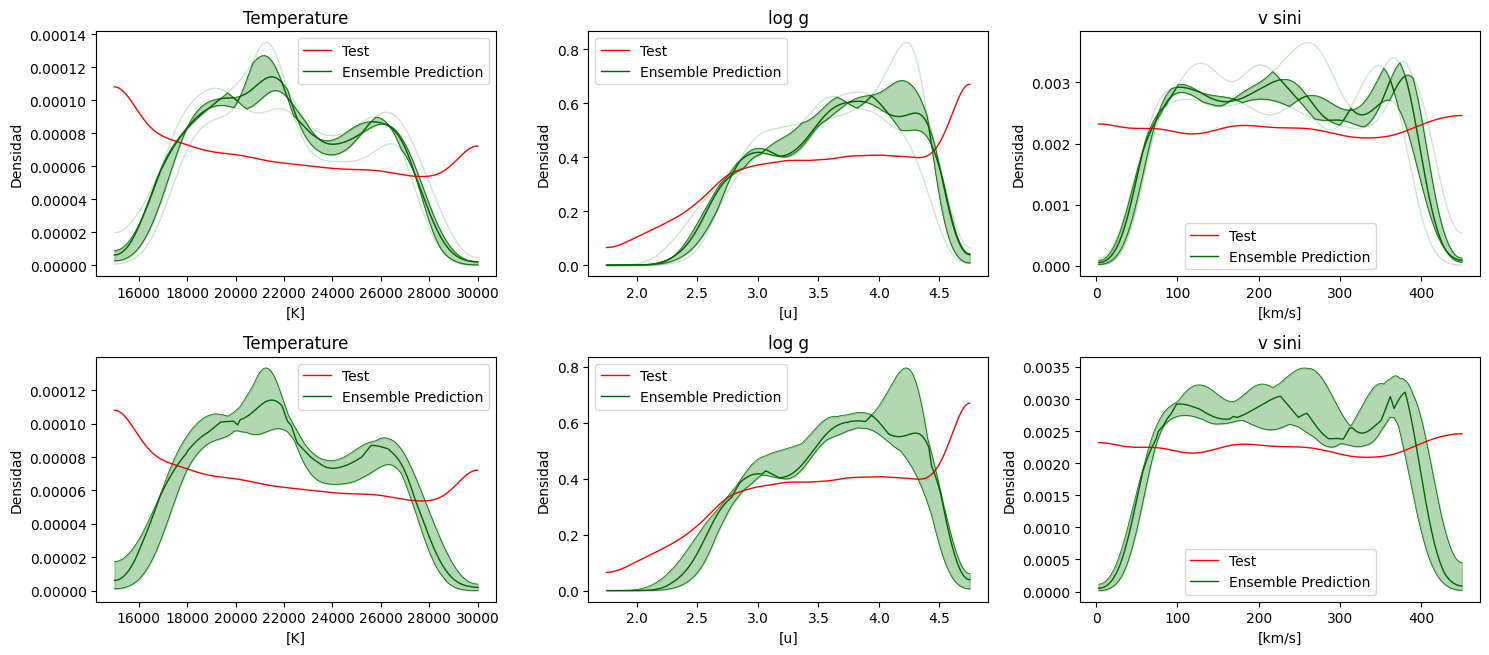

In [34]:
# Ref: https://stackoverflow.com/questions/60130503/plotting-bars-hist-and-pdf-line-via-kdeplot
import scipy.stats as st
from scipy.interpolate import interp1d

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,6.66))

for i, featureName in enumerate(target):
	x_space = np.linspace(Y[featureName].min(), Y[featureName].max(), 2**12)
	heights = []
	for j in range(NUM_MODELS):
		prediction_y = predictions[j,:,i] # your data goes here
		x,y,prediction_kde = SKL_density_plot(prediction_y, axes[0,i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color = 'green',alpha=0.2)
		f = interp1d(x, y, kind="linear", assume_sorted=True)
		h = f(x_space)*3
		heights.append(h)
  
	heights = np.array(heights)
 
	rescaled_y = y_scaler.inverse_transform(y_test)[:,i]
	x,y,test_kde = SKL_density_plot(rescaled_y, axes[0,i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color = 'red',label='Test')
	x,y,test_kde = SKL_density_plot(rescaled_y, axes[1,i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color = 'red',label='Test')
	f = interp1d(x, y, kind="linear", assume_sorted=True)
	test_h = f(x_space)
 
	# cuantiles 50% de los datos
	q25 = np.quantile(heights,0.25,axis=0)
	q75 = np.quantile(heights,0.75,axis=0)
	axes[0,i].plot(x_space, np.median(heights,axis=0),color='darkGreen',alpha=1,linewidth=1,label='Ensemble Prediction')
	axes[0,i].plot(x_space, q25,color='darkGreen',alpha=1,linewidth=0.5)
	axes[0,i].plot(x_space, q75,color='darkGreen',alpha=1,linewidth=0.5)
	axes[0,i].fill_between(x_space, q25,q75, alpha=0.30, color='green')
	
	# cuantiles 95% de los datos
	q5 = np.quantile(heights,0.05,axis=0)
	q95 = np.quantile(heights,0.95,axis=0)
	axes[1,i].plot(x_space, np.median(heights,axis=0),color='darkGreen',alpha=1,linewidth=1,label='Ensemble Prediction')
	axes[1,i].plot(x_space, q5,color='darkGreen',alpha=1,linewidth=0.5)
	axes[1,i].plot(x_space, q95,color='darkGreen',alpha=1,linewidth=0.5)
	axes[1,i].fill_between(x_space, q5,q95, alpha=0.30, color='green')
	
	measure = ['Temperature','log g', 'v sini']
	measure_unit = ['[K]', '[u]', '[km/s]']
	axes[1,i].set_xlabel(measure_unit[i])
	axes[1,i].set_ylabel('Densidad')
	axes[1,i].legend()
	axes[1,i].set_title(measure[i])

	axes[0,i].set_xlabel(measure_unit[i])
	axes[0,i].set_ylabel('Densidad')
	axes[0,i].legend()
	axes[0,i].set_title(measure[i])


plt.tight_layout()
plt.show()

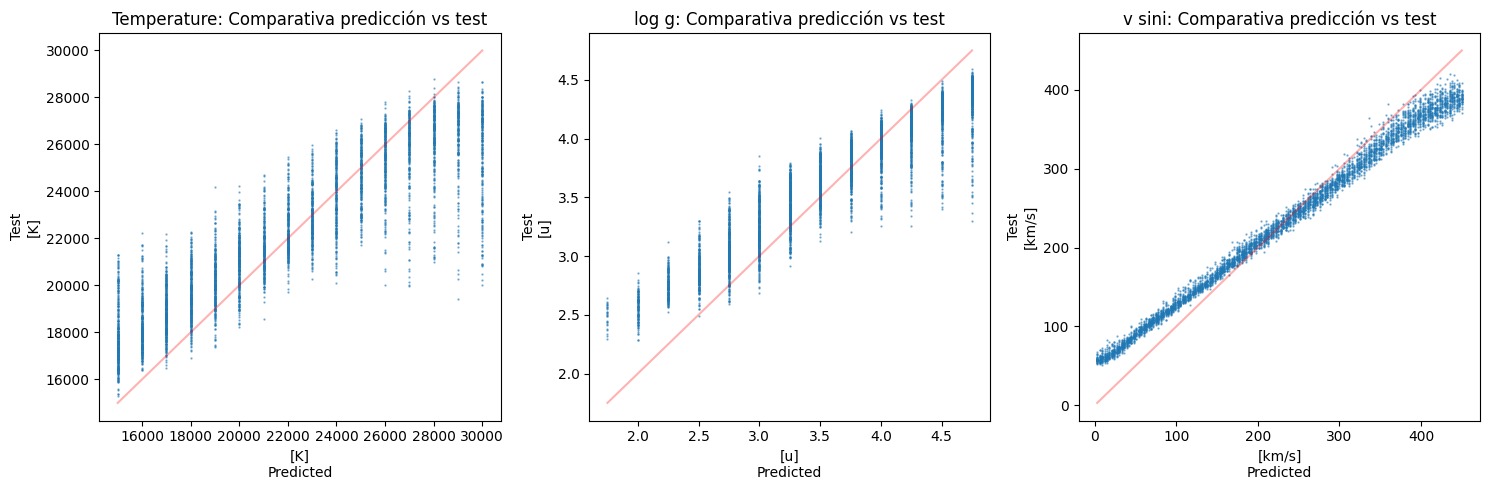

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for i, featureName in enumerate(target):
	x_space = np.linspace(y_scaler.inverse_transform(y_test)[:,i].min(), y_scaler.inverse_transform(y_test)[:,i].max(), 100)
	axes[i].scatter(x=y_scaler.inverse_transform(y_test)[:,i],y=ensemble_prediction[:,i],s=0.5,alpha=0.5)
	axes[i].plot(x_space,x_space,c='red',alpha=0.3)
	axes[i].set_xlabel(measure_unit[i]+'\nPredicted')
	axes[i].set_ylabel('Test\n'+measure_unit[i])
	axes[i].set_title(measure[i]+': Comparativa predicción vs test')
 
plt.tight_layout();
plt.show()

c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.w

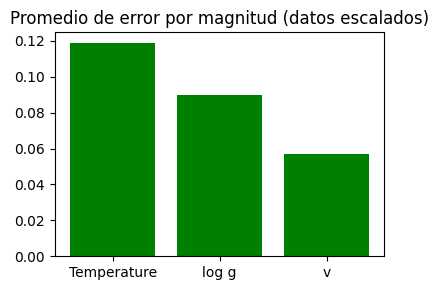

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4,3))
x_data = ['Temperature','log g','v']

diff = np.mean(np.array([np.abs(y_scaler.transform(y_hat)-y_test) for y_hat in predictions]),axis=(0,1))
axes.bar(x_data,diff, color='green')
axes.set_title('Promedio de error por magnitud (datos escalados)')
plt.tight_layout();
plt.show()


In [37]:
# / TODO Error relativo-absoluto agregado en la tabla
# / TODO scatter de valor esperado sobre prediccion
# / TODO graficar comparativa entre estrella sitentica y real
# / TODO grafica con vecindario de espectro real

In [38]:
# dataframe
inverse_y_test = y_scaler.inverse_transform(y_test)
results = pd.DataFrame({
  'Temp':inverse_y_test[:,0],'Temp_pred':ensemble_prediction[:,0],'Temp_Variance':uncertainty[:,0],
  'log_g':inverse_y_test[:,1],'log_g_pred':ensemble_prediction[:,1],'log_g_Variance':uncertainty[:,1],
  'v':inverse_y_test[:,2],'v_pred':ensemble_prediction[:,2],'v_Variance':uncertainty[:,2]
                    })
results.head(10)

,Temp,Temp_pred,Temp_Variance,log_g,log_g_pred,log_g_Variance,v,v_pred,v_Variance
0,17000.0,18496.183594,235.183517,3.25,3.595864,0.099516,246.0,239.972672,6.724946
1,18000.0,17824.613281,718.749695,2.75,3.061373,0.115508,285.0,271.265930,5.846228
2,30000.0,25751.964844,271.177887,3.75,3.725275,0.038867,267.0,255.887634,10.060784
3,23000.0,20942.357422,369.473328,2.50,2.686096,0.009534,63.0,97.842705,4.279080
4,19000.0,20812.839844,657.150696,3.00,3.191908,0.136918,126.0,146.404465,9.183016
5,17000.0,17648.865234,399.421234,4.50,4.113754,0.086954,156.0,184.440094,10.790162
6,28000.0,21846.746094,1160.020752,3.25,2.995538,0.126459,450.0,387.983948,6.826966
7,22000.0,21572.511719,321.732117,4.00,4.106198,0.128586,285.0,276.567505,16.125078
8,23000.0,23470.074219,310.418121,3.00,3.190351,0.078339,30.0,72.588951,8.741224
9,23000.0,22689.984375,595.011658,4.50,4.367792,0.138501,153.0,172.569611,13.102196


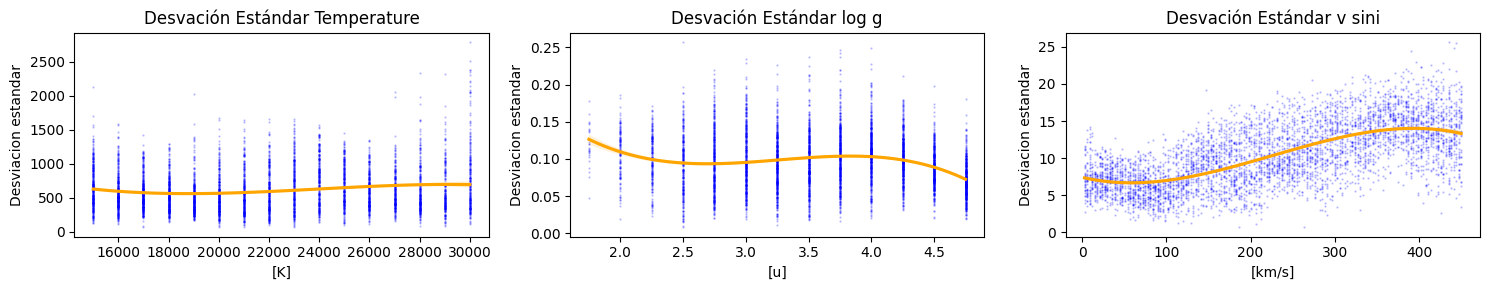

In [39]:
# TODO: algo que permita ver el tamano de las varianzas sobre target feature
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,3))
feat=['Temp', 'log_g',	'v']
vari=['Temp_Variance','log_g_Variance','v_Variance']
measure = ['Temperature','log g', 'v sini']
measure_unit = ['[K]', '[u]', '[km/s]']

for i, featureName in enumerate(target):
	x_data = y_scaler.inverse_transform(y_test)[:,i]
	y_data = uncertainty[:,i]
	sns.regplot(x=feat[i], y=vari[i], data=results,ax=axes[i],scatter_kws=dict(alpha=0.2,color='blue',s=0.5),line_kws=dict(color='orange'), order=3);
	axes[i].set_xlabel(measure_unit[i])
	axes[i].set_ylabel("Desviacion estandar")
	axes[i].set_title('Desvación Estándar '+measure[i])
	#axes[i].legend()
  
plt.tight_layout()
plt.show()

### Datos observados vs predicción (ensamble)

In [49]:
# generar predicciones e incerteza de ensamble
predictions = np.array([y_scaler.inverse_transform(model.predict(formatted_x_obs)) for model in models])
ensemble_prediction = sum([predictions[i]*weights[i] for i in range(len(models))])
uncertainty = sum([(predictions[i]-ensemble_prediction)**2*weights[i] for i in range(len(models))])**(1/2)

3/3 [==============================] - 0s 19ms/step


### Individual ensemble metrics(observed data)

In [51]:
# metricas por parametro
losses = []
maes = []
predictions = y_scaler.transform(ensemble_prediction)

for i in range(len(target)):
  losses.append(np.mean((predictions[:,i]-y_obs[:,i])**2))
  maes.append(np.mean(np.abs(predictions[:,i]-y_obs[:,i])))
  
print('Temperatura - loss: %.3f  MAE:%.3f'% (losses[0],maes[0]))
print('log g -       loss: %.3f  MAE:%.3f'% (losses[1],maes[1]))
print('v -           loss: %.3f  MAE:%.3f'% (losses[2],maes[2]))


Temperatura - loss: 0.192  MAE:0.354
log g -       loss: 0.021  MAE:0.118
v -           loss: 0.031  MAE:0.121


c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


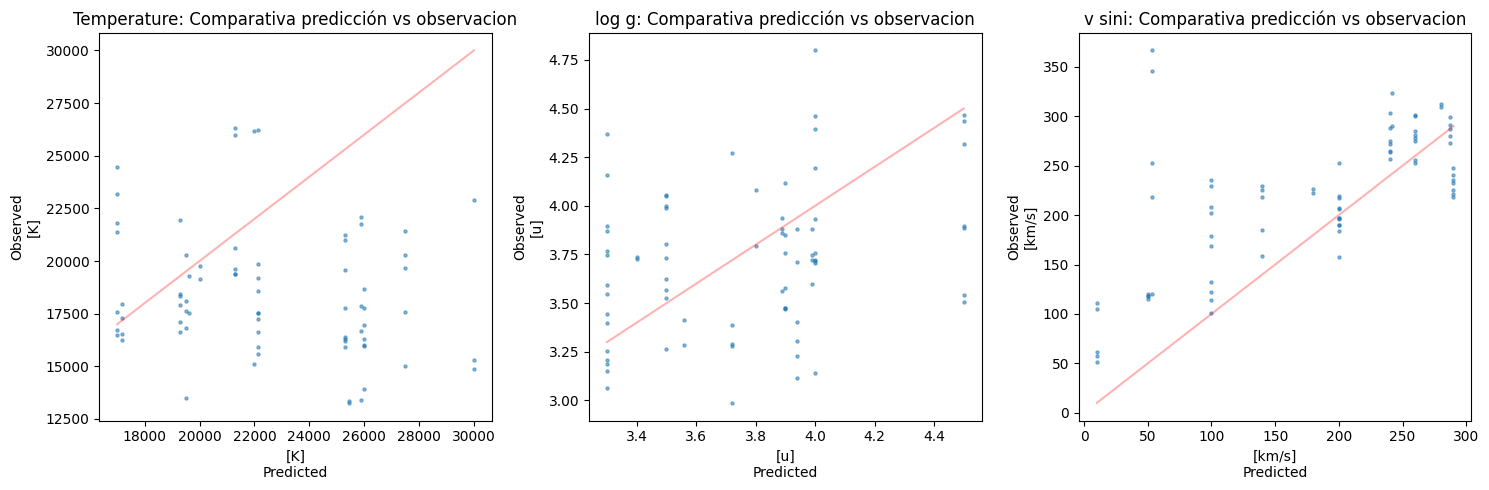

In [41]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for i, featureName in enumerate(target):
	x_space = np.linspace(y_scaler.inverse_transform(y_obs)[:,i].min(), y_scaler.inverse_transform(y_obs)[:,i].max(), 100)
	axes[i].scatter(x=y_scaler.inverse_transform(y_obs)[:,i],y=ensemble_prediction[:,i],s=5,alpha=0.5)
	axes[i].plot(x_space,x_space,c='red',alpha=0.3)
	axes[i].set_xlabel(measure_unit[i]+'\nPredicted')
	axes[i].set_ylabel('Observed\n'+measure_unit[i])
	axes[i].set_title(measure[i]+': Comparativa predicción vs observacion')
 
plt.tight_layout();
plt.show()

In [42]:
# data processing for formatted table

# error sign: ±

table_formatted_temperature_pred = [str(round(i))+' ± '+str(round(j)) for i,j in zip(ensemble_prediction[:,0],uncertainty[:,0])]
table_formatted_log_g_pred = [str(round(i,2))+' ± '+str(round(j,2)) for i,j in zip(ensemble_prediction[:,1],uncertainty[:,1])]
table_formatted_v_pred = [str(round(i))+' ± '+str(round(j)) for i,j in zip(ensemble_prediction[:,2],uncertainty[:,2])]

#data formatting
inverse_y_obs = y_scaler.inverse_transform(y_obs)
rel_error = np.abs(ensemble_prediction-inverse_y_obs)*(1/inverse_y_obs)*100
abs_error = np.abs(ensemble_prediction-inverse_y_obs)

table_formatted_temperature = [str(round(i)) for i in np.round(inverse_y_obs[:,0],0)]
table_formatted_log_g = [str(round(i,2)) for i in np.round(inverse_y_obs[:,1],2)]
table_formatted_v = [str(round(i)) for i in np.round(inverse_y_obs[:,2],0)]

table_formatted_temperature_error = [str(np.round(i))+' ('+str(np.round(j,1))+'%)' for i,j in zip(abs_error[:,0],rel_error[:,0])]
table_formatted_log_g_error = [str(np.round(i,2))+' ('+str(np.round(j,1))+'%)' for i,j in zip(abs_error[:,1],rel_error[:,1])]
table_formatted_v_error = [str(np.round(i))+' ('+str(np.round(j,1))+'%)' for i,j in zip(abs_error[:,2],rel_error[:,2])]

In [43]:
# dataframe comparativo de datos observados
inverse_y_obs = y_scaler.inverse_transform(y_obs)
results = pd.DataFrame({
  'Temperatura':table_formatted_temperature,'Prediccion_Temperatura':table_formatted_temperature_pred,'Temp_Error_Abs(Rel)':table_formatted_temperature_error,
  'log_g':table_formatted_log_g,'Prediccion_log_g':table_formatted_log_g_pred,'log_g_Error_Abs(Rel)':table_formatted_log_g_error,
  'v':table_formatted_v,'Prediccion_v':table_formatted_v_pred,'v_Error_Abs(Rel)':table_formatted_v_error,
  'paramCloseXi': table_formatted_xi
                    })
Obs_df[['HD','date','time']].join(results).set_index('HD').head(60)

,date,time,Temperatura,Prediccion_Temperatura,Temp_Error_Abs(Rel),log_g,Prediccion_log_g,log_g_Error_Abs(Rel),v,Prediccion_v,v_Error_Abs(Rel),paramCloseXi
HD,,,,,,,,,,,,
33328,2012-11-13,05-37-18,19526,16838 ± 275,2688.0 (13.8%),3.0,3.87 ± 0.09,0.57 (17.4%),287,273 ± 10,14.0 (4.9%),100.145347
33328,2013-01-18,03-39-09,19526,18125 ± 707,1401.0 (7.2%),3.0,3.75 ± 0.07,0.45 (13.6%),287,280 ± 12,7.0 (2.5%),88.230602
33328,2013-02-26,00-55-34,19526,20307 ± 599,781.0 (4.0%),3.0,3.59 ± 0.11,0.29 (8.9%),287,291 ± 10,4.0 (1.6%),93.982720
33328,2015-02-25,23-58-07,19526,13480 ± 1436,6046.0 (31.0%),3.0,4.37 ± 0.16,1.07 (32.4%),287,300 ± 14,13.0 (4.4%),116.914635
33328,2015-02-26,00-19-03,19526,17622 ± 370,1904.0 (9.8%),3.0,4.16 ± 0.09,0.86 (26.0%),287,287 ± 13,0.0 (0.2%),111.190865
35165,2014-03-20,23-53-54,17000,16703 ± 800,297.0 (1.7%),4.0,4.4 ± 0.14,0.4 (9.9%),240,264 ± 8,24.0 (10.0%),175.906493
35165,2014-03-21,00-14-49,17000,17583 ± 791,583.0 (3.4%),4.0,4.46 ± 0.16,0.46 (11.6%),240,265 ± 14,25.0 (10.6%),172.360638
35165,2014-03-21,00-35-18,17000,16472 ± 841,528.0 (3.1%),4.0,4.2 ± 0.07,0.2 (4.9%),240,257 ± 12,17.0 (7.0%),172.762155
35165,2015-11-14,04-22-43,17000,24459 ± 3601,7459.0 (43.9%),4.0,3.76 ± 0.45,0.24 (6.1%),240,288 ± 20,48.0 (19.9%),162.566641


In [44]:
# total execution time print
execution_time = float(time.time() - start_time)
print_time(execution_time)

--- Total: 0 hours, 14 minutes, 46.427264 seconds  ---
